[*********************100%***********************]  1 of 1 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2301 entries, 2015-11-19 to 2025-01-14
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Adj Close, SQ)  2301 non-null   float64
 1   (Close, SQ)      2301 non-null   float64
 2   (High, SQ)       2301 non-null   float64
 3   (Low, SQ)        2301 non-null   float64
 4   (Open, SQ)       2301 non-null   float64
 5   (Volume, SQ)     2301 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 125.8 KB
2015 29
2016 252
2017 251
2018 251
2019 252
2020 253
2021 252
2022 251
2023 250
2024 252
2025 8
(1540, 100, 1) (1540, 1)
(661, 100, 1) (661, 1)
Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1540/1540 ━━━━━━━━━━━━━━━━━━━━ 147s 93ms/step - loss: 0.0044
Epoch 2/2
1540/1540 ━━━━━━━━━━━━━━━━━━━━ 204s 94ms/step - loss: 0.0015


<Figure size 1500x500 with 0 Axes>

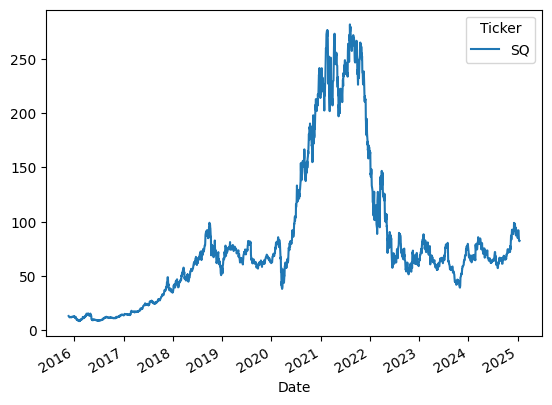

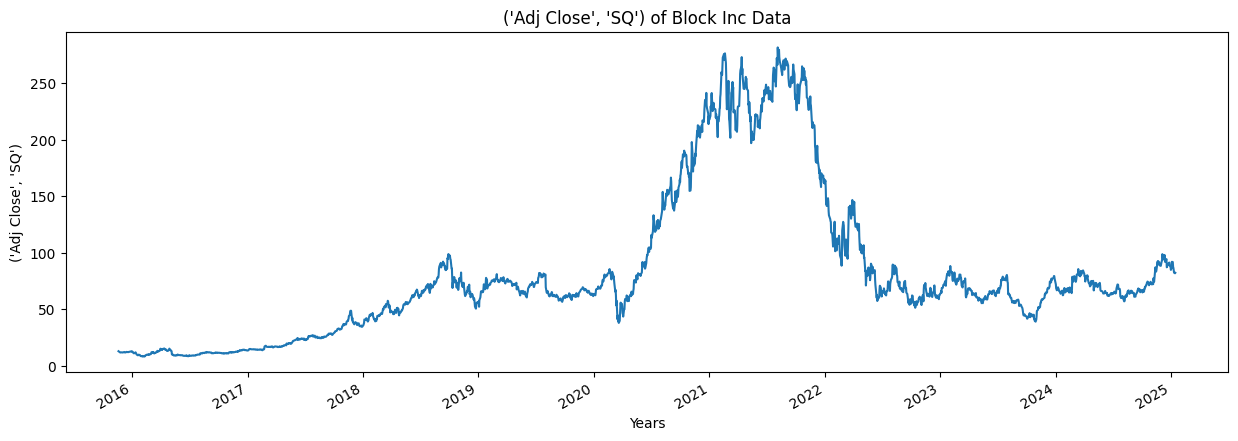

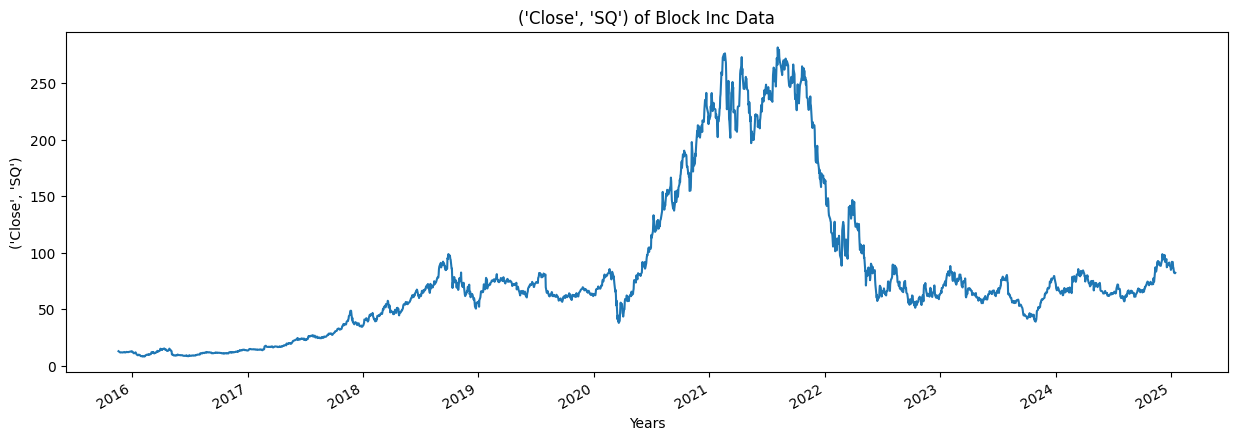

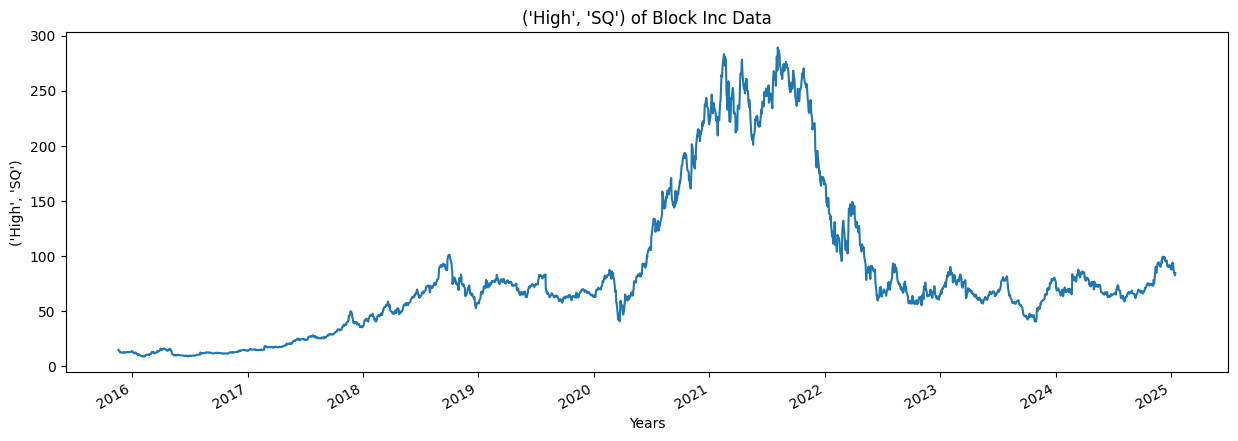

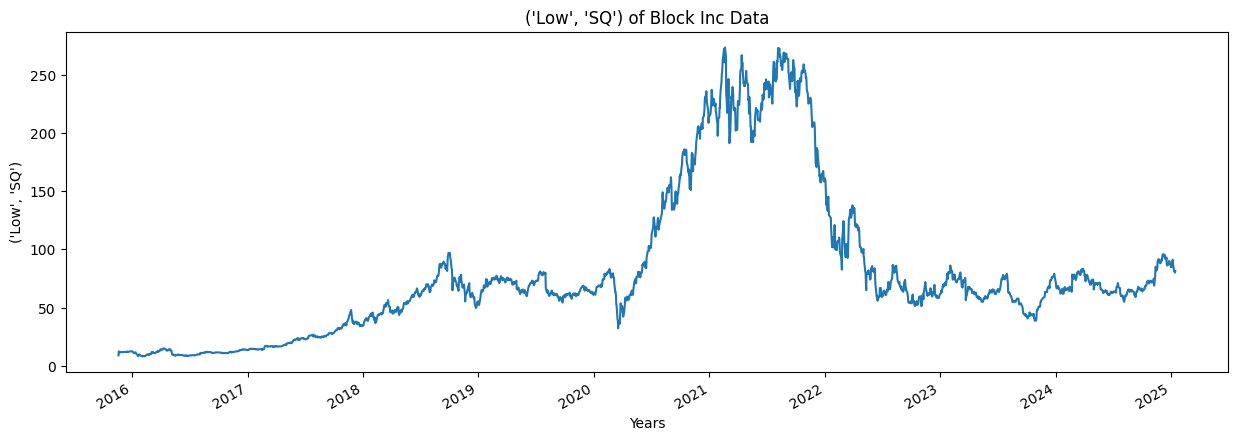

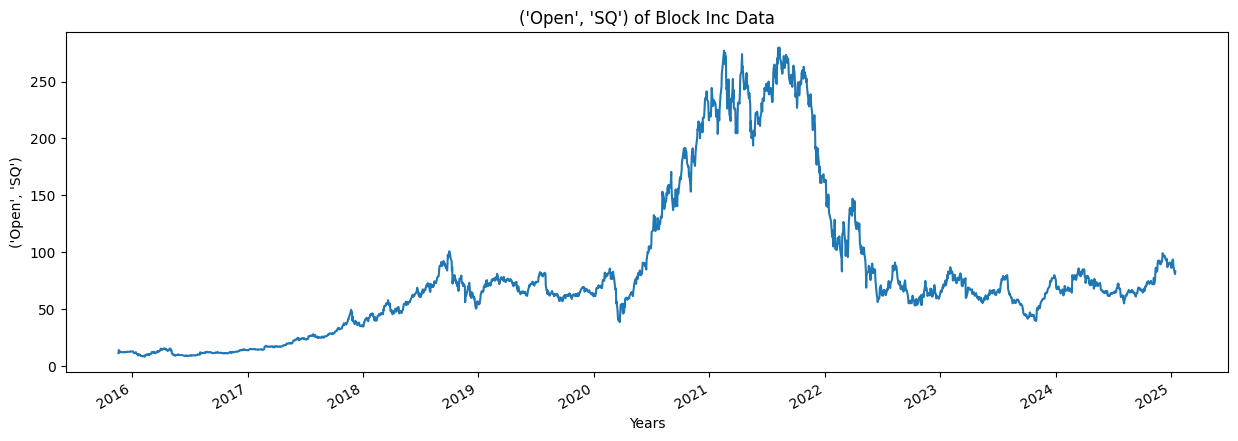

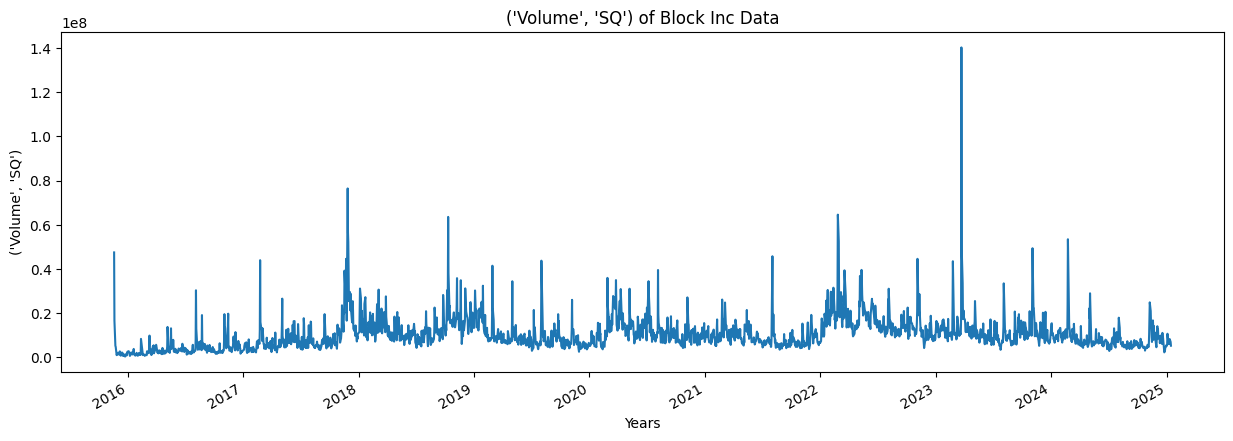

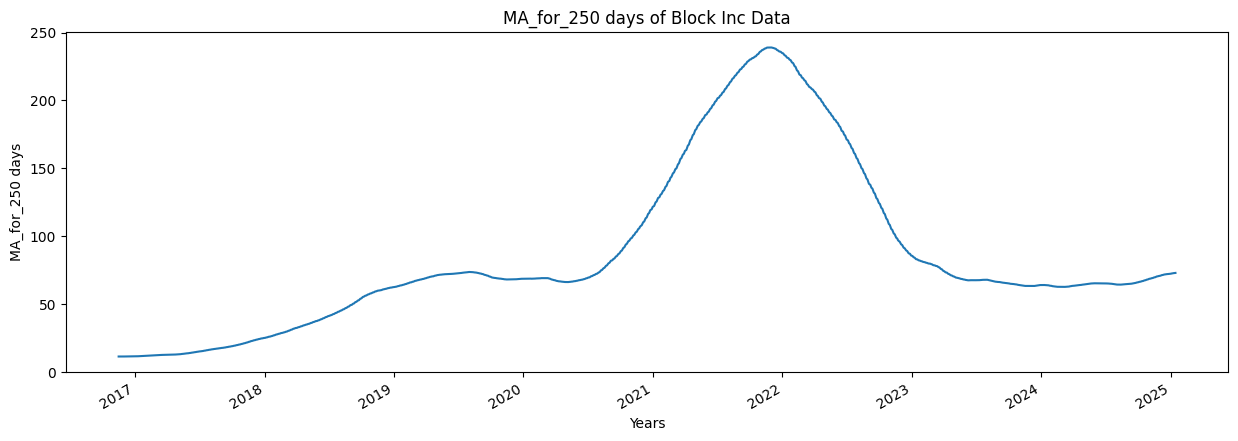

<Figure size 1500x500 with 0 Axes>

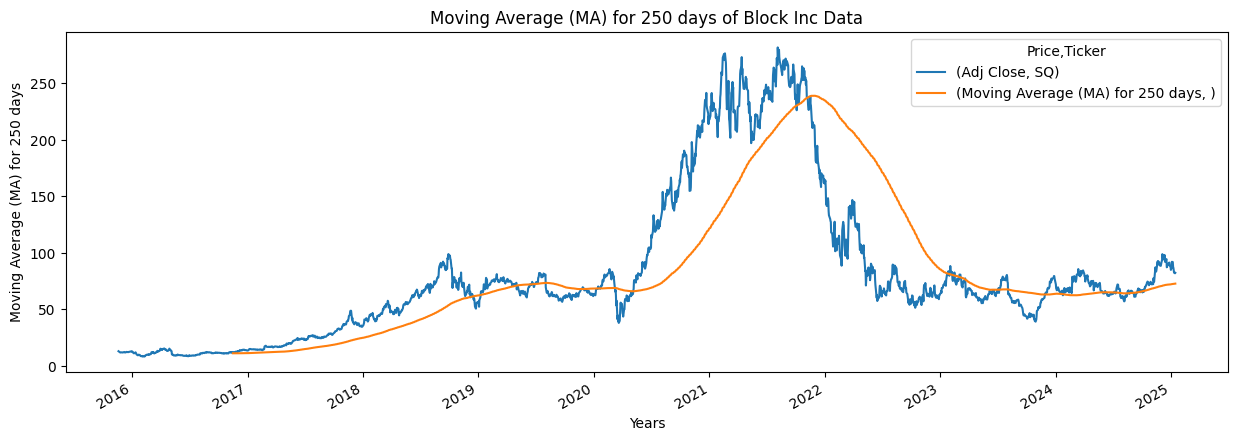

<Figure size 1500x500 with 0 Axes>

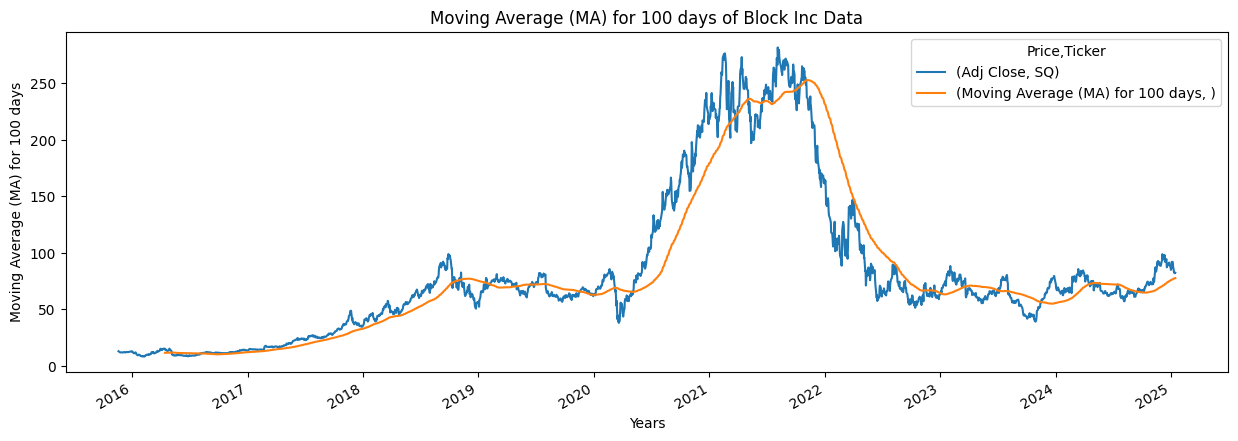

<Figure size 1500x500 with 0 Axes>

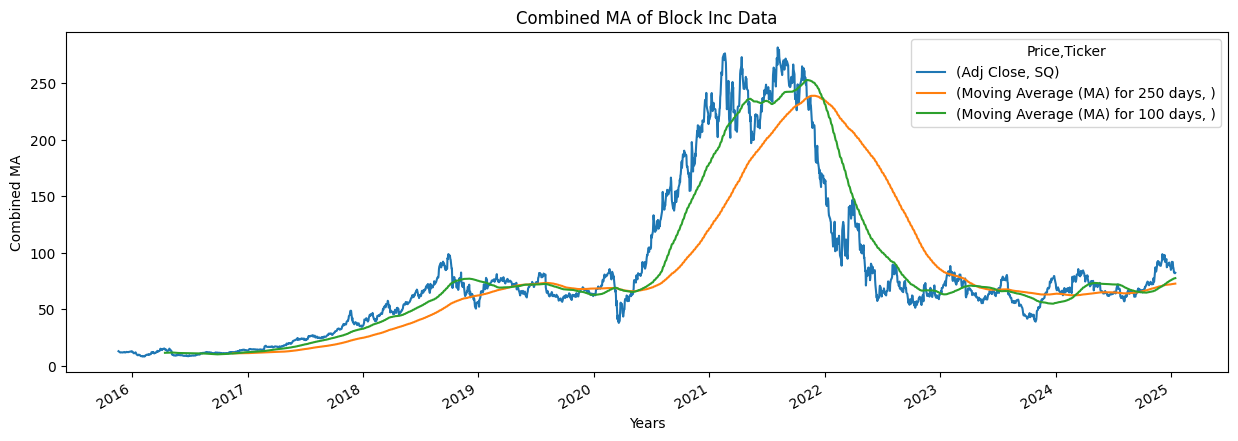

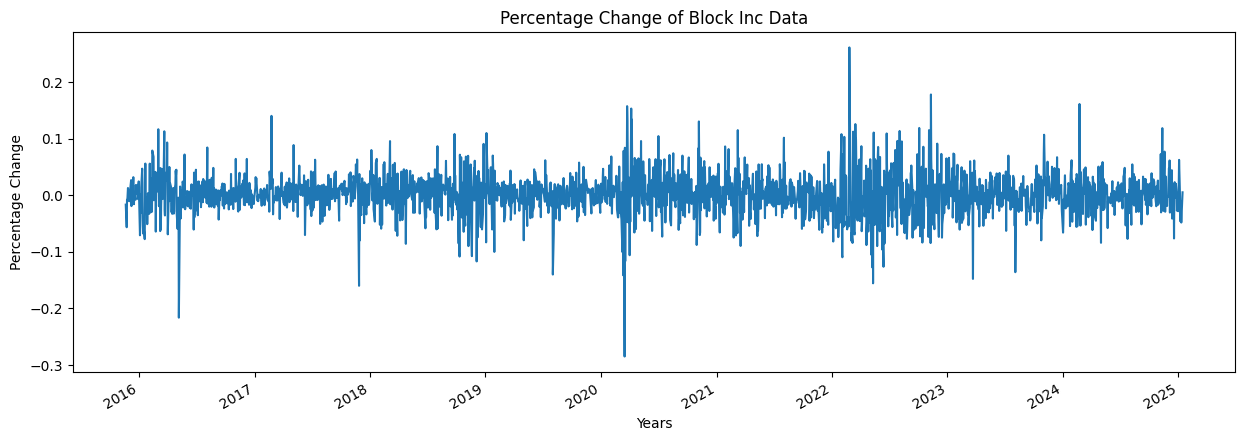

In [22]:
#Need to install finance package
!pip install yfinance
import yfinance as yf


#Need to define start and end dates to define scope of Stock values
from datetime import datetime
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day) #can subtract 20 years from current year


#Initalize Stock variable
stock = "SQ"
blockinc_data = yf.download(stock, start, end)


#Visualize data from past 10 years
blockinc_data.head()       #table data
blockinc_data.shape        #shape of table (rows, columns)
blockinc_data.describe()   #data statisitics
blockinc_data.info()       #data types inside data set (null values, floats, etc)
blockinc_data.isna().sum() #checks for any null values and sums it up, if zero then data is clean set


#Graphing Data
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (15,5))
blockinc_data['Adj Close'].plot() #using Ajd Close Price as it is more accurate than Close Price


#Creating Function to plot graphs for each stock input by user
def plot_graph(figsize, values, column_name):
  plt.figure(figsize = (15,5))
  values.plot(figsize = figsize)

  plt.xlabel("Years")
  plt.ylabel(column_name)
  plt.title(f"{column_name} of Block Inc Data")

blockinc_data.columns


#For loop to graph each with columns
for column in blockinc_data.columns:
  plot_graph((15,5), blockinc_data[column], column)


#Pandas Dataframe
##We will be inputting data to neural network to train and predict following day stock data##
import pandas as pd
data = pd.DataFrame(blockinc_data)
data.head()

for i in range(2015,2026):                          #counting number of days of each year stock data accounts for
  print(i, list(blockinc_data.index.year).count(i))


#Moving Average Method (MA) for 250 Days
blockinc_data['Moving Average (MA) for 250 days'] = blockinc_data['Adj Close'].rolling(250).mean()
plot_graph((15,5), blockinc_data['Moving Average (MA) for 250 days'], 'MA_for_250 days')
plot_graph((15,5), blockinc_data[['Adj Close', 'Moving Average (MA) for 250 days']], 'Moving Average (MA) for 250 days') #plots MA and Adj Close Price


#Moving Average Method (MA) for 100 Days
blockinc_data['Moving Average (MA) for 100 days'] = blockinc_data['Adj Close'].rolling(100).mean()
plot_graph((15,5), blockinc_data[['Adj Close', 'Moving Average (MA) for 100 days']], 'Moving Average (MA) for 100 days')


#Combined MA Plot
plot_graph((15,5), blockinc_data[['Adj Close', 'Moving Average (MA) for 250 days', 'Moving Average (MA) for 100 days']], 'Combined MA') #the 100 days curve (green) is closer to the actual Adj Close data than the 250 days curve


#Percentage Change
blockinc_data['Percentage Change'] = blockinc_data['Adj Close'].pct_change()
plot_graph((15,5), blockinc_data['Percentage Change'], 'Percentage Change')

Adj_Close_Price = blockinc_data['Adj Close']
max(Adj_Close_Price.values),min(Adj_Close_Price.values) #shows max and min adj close price values in array form


#Converting data 0 to 1 range easier to train model rather than 8 - 281 (min and max values of stock)
from sklearn.preprocessing import MinMaxScaler #importing MinMax Scaler to scale down range
scaler = MinMaxScaler(feature_range = (0,1))   # 0 to 1 range --> easier for model to train
scaled_data = scaler.fit_transform(Adj_Close_Price)
scaled_data

len(scaled_data) #shows that the scaled data is same length as the original set from yfinance package


# MA Concept 100 (as our graph shows 100 is closer to true value rather than 250 day) rows to use as Input Training Data
## 1 to 100 to predict 101 row, and 2 to 101 to predict 102, and so forth till dataset ends at 2301
x_data = []
y_data = []

for i in range(100, len(scaled_data)): #need to start at row 100 or bc 99 or before wont have enough days for the 100 day MA
  x_data.append(scaled_data[i-100:i])
  y_data.append(scaled_data[i])        #predicting y values by using x data


#Numpy (converting x and y data into Numpy Arrays to make easier for analysis)
import numpy as np
x_data = np.array(x_data)
y_data = np.array(y_data)

x_data[0], y_data[0] #presents 100 rows of entrys for x array and predicts following y to be 0.02179637 at 101 row


#Splitting Data into Training and Testing Sets (70/30 split for training and testing split)
int(len(x_data)*0.7) # = 1540, 30% = 2301 - 100 - 1540 = 661

len_split = int(len(x_data)*0.7)

x_training = x_data[:len_split] #splitting array length by indexing
y_training = y_data[:len_split]

x_testing = x_data[len_split:]
y_testing = y_data[len_split:]

print(x_training.shape, y_training.shape)
print(x_testing.shape, y_testing.shape)


#Neural Network Long Short-Term Memory (LSTM) Model to Predict Closing Price using Keras (Keras is a high-level neural networks API that can run on top of TensorFlow)
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (x_training.shape[1], 1))) #128 neurons, return seq values as true becuase input to the next layer is either a single vector or sequence of vectors and we are inputting seq of vectors
model.add(LSTM(64, return_sequences = False))                                         #second layer is also LSTM but 64 neurons, return seq value is false as not being returned as a sequence
model.add(Dense(25))                                                                  #25 neuron
model.add(Dense(1))                                                                   #1 neuron for the final layer

#Compiling Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error') #optimizer Adam algorithm allows to optimize the running of the model, loss is matrix using Mean Squared Error

#Model Fitting (using training data to fit into model)
model.fit(x_training, y_training, batch_size = 1, epochs = 2) #batch size will segregate our input data that is training data into batches --> I am using default value of 1, epochs will train data set into second training session after alr being done in batch --> I am using 2, but don't use too many else too long and can cause overfitting


In [23]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [24]:
#Predicting Stock Data using Model using Test Data (not 70% Training Data)
stock_prediction = model.predict(x_testing) #is for x testing rn, will need to do y test as well

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step


In [25]:
stock_prediction

array([[0.25103688],
       [0.2556259 ],
       [0.27347192],
       [0.28365672],
       [0.278645  ],
       [0.27909952],
       [0.27420294],
       [0.27009532],
       [0.2697976 ],
       [0.27115113],
       [0.26031718],
       [0.24332878],
       [0.21809791],
       [0.19722232],
       [0.19017608],
       [0.18288864],
       [0.18014164],
       [0.18286674],
       [0.18630211],
       [0.19792923],
       [0.21259673],
       [0.21950765],
       [0.21496147],
       [0.20557849],
       [0.1946978 ],
       [0.19122288],
       [0.19576693],
       [0.19869147],
       [0.20539692],
       [0.2082331 ],
       [0.20306854],
       [0.19997211],
       [0.19743346],
       [0.19361672],
       [0.19618341],
       [0.20025502],
       [0.20758288],
       [0.221112  ],
       [0.2309956 ],
       [0.23111376],
       [0.22734006],
       [0.21631403],
       [0.21688591],
       [0.22389862],
       [0.23241769],
       [0.24069023],
       [0.24740843],
       [0.264

In [26]:
#Inverse Transform Data to Find Values in terms of Original Stock Data
inverse_predictor = scaler.inverse_transform(stock_prediction)
inverse_predictor

array([[77.01352 ],
       [78.26834 ],
       [83.148155],
       [85.93309 ],
       [84.56269 ],
       [84.68697 ],
       [83.348045],
       [82.22486 ],
       [82.14345 ],
       [82.51356 ],
       [79.551125],
       [74.905815],
       [68.00669 ],
       [62.298473],
       [60.37175 ],
       [58.37907 ],
       [57.62793 ],
       [58.37308 ],
       [59.31245 ],
       [62.49177 ],
       [66.50245 ],
       [68.39217 ],
       [67.14906 ],
       [64.58338 ],
       [61.608166],
       [60.657986],
       [61.90051 ],
       [62.700195],
       [64.53374 ],
       [65.30926 ],
       [63.89706 ],
       [63.050373],
       [62.356205],
       [61.312557],
       [62.014393],
       [63.127735],
       [65.13146 ],
       [68.830864],
       [71.53343 ],
       [71.56574 ],
       [70.53387 ],
       [67.51891 ],
       [67.675285],
       [69.592834],
       [71.922295],
       [74.18433 ],
       [76.02136 ],
       [80.63534 ],
       [84.86133 ],
       [86.35105 ],


In [27]:
#Inverse Transform y testing data
inverse_y_testing = scaler.inverse_transform(y_testing)
inverse_y_testing

array([[83.41000366],
       [90.51999664],
       [87.51000214],
       [81.91000366],
       [87.44000244],
       [83.09999847],
       [83.37999725],
       [84.59999847],
       [84.75      ],
       [76.58000183],
       [71.87000275],
       [62.75999832],
       [60.29999924],
       [62.90999985],
       [57.50999832],
       [58.50999832],
       [60.52000046],
       [60.65000153],
       [67.26999664],
       [71.        ],
       [69.43000031],
       [65.59999847],
       [63.84000015],
       [61.45999908],
       [63.90000153],
       [66.73000336],
       [64.97000122],
       [68.62999725],
       [67.01999664],
       [63.22999954],
       [65.02999878],
       [64.15000153],
       [62.41999817],
       [65.98000336],
       [66.26999664],
       [69.25      ],
       [74.77999878],
       [74.76000214],
       [71.80000305],
       [71.43000031],
       [66.38999939],
       [72.76000214],
       [74.68000031],
       [76.05999756],
       [77.80999756],
       [79

In [29]:
#Error Calculations via Root Mean Square Error
RMSE = np.sqrt(np.mean(inverse_predictor - inverse_y_testing)**2)
RMSE # 2 is pretty low error

2.016947476477919

In [30]:
#Overall Graph Visualization
data_plot = pd.DataFrame(
 {
  'original_testing_data': inverse_y_testing.reshape(-1),
  'predicted_testing_data': inverse_predictor.reshape(-1)
 },
    index = blockinc_data.index[len_split+100:]
)

data_plot.head()

,original_testing_data,predicted_testing_data
Date,,
2022-05-26,83.410004,77.013519
2022-05-27,90.519997,78.268341
2022-05-31,87.510002,83.148155
2022-06-01,81.910004,85.933090
2022-06-02,87.440002,84.562691


<Figure size 1500x500 with 0 Axes>

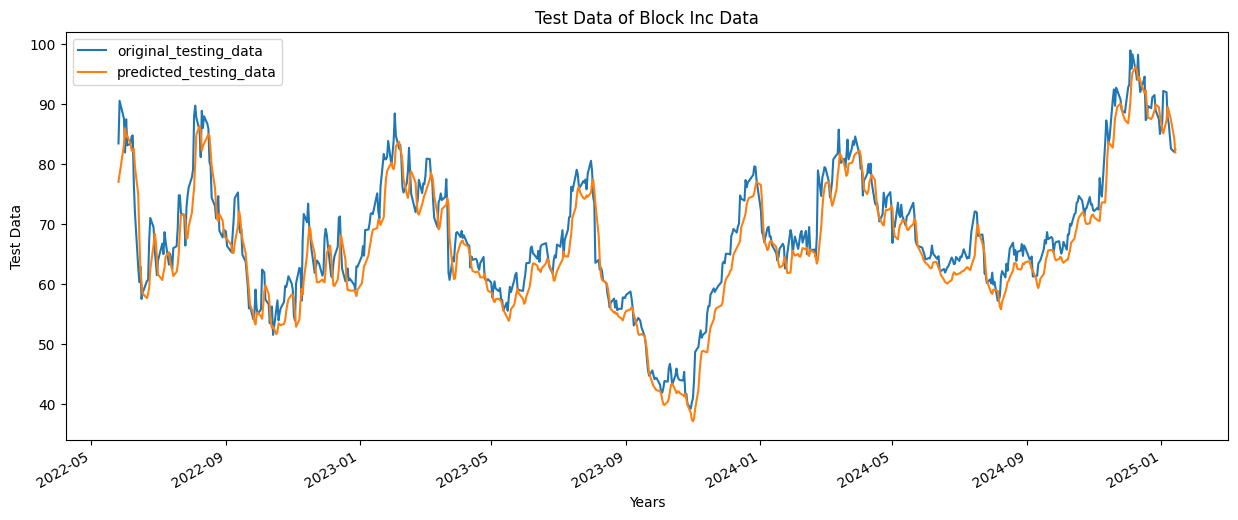

In [33]:
plot_graph((15,6), data_plot, 'Test Data')

<Figure size 1500x500 with 0 Axes>

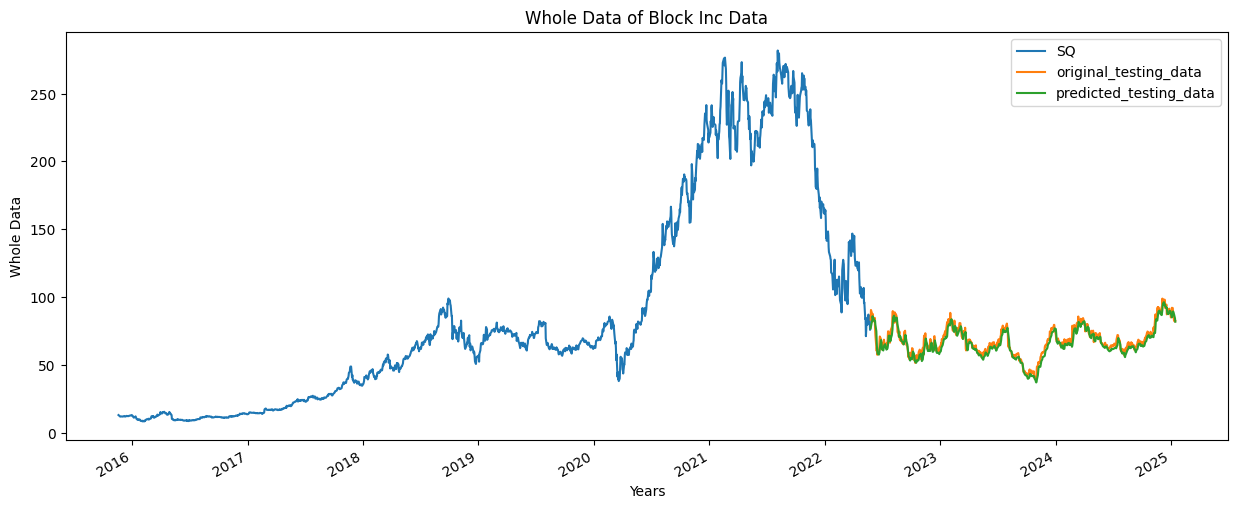

In [34]:
plot_graph((15,6), pd.concat([Adj_Close_Price[:len_split+100], data_plot], axis=0), 'Whole Data')

In [36]:
#Need to save the model
model.save('New_Stock_Price_Prediction_Model.keras')